In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from helper import *

pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline

In [2]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [3]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [4]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

print(data[data.isna().any(axis="columns")].shape[0])

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')

100


# Statcast Predictions

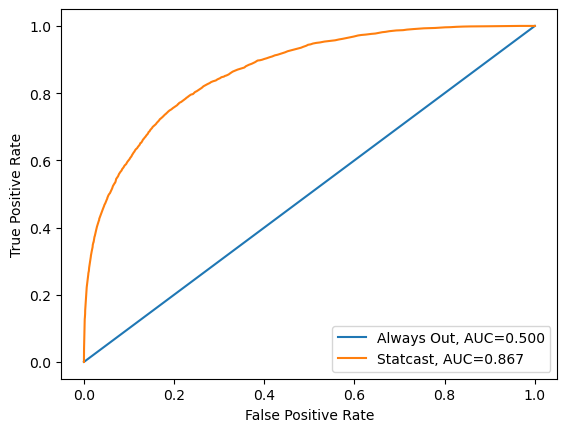

In [5]:
always_out = np.zeros_like(data['is_hit'])
plt.figure(0).clf()

fpr_ao, tpr_ao, _ = roc_curve(data['is_hit'], always_out)
auc_ao = roc_auc_score(data['is_hit'], always_out)
fpr_statcast, tpr_statcast, _ = roc_curve(data['is_hit'], data['estimated_ba_using_speedangle'])
auc_statcast = roc_auc_score(data['is_hit'], data['estimated_ba_using_speedangle'])

plt.plot(fpr_ao, tpr_ao, label=f"Always Out, AUC={auc_ao:0.3f}")
plt.plot(fpr_statcast, tpr_statcast, label=f"Statcast, AUC={auc_statcast:0.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

            Accuracy  Sensitivity  Specificity  F1 Score
Always Out  0.673364     0.000000     1.000000  0.000000
Statcast    0.802624     0.602045     0.899921  0.665847


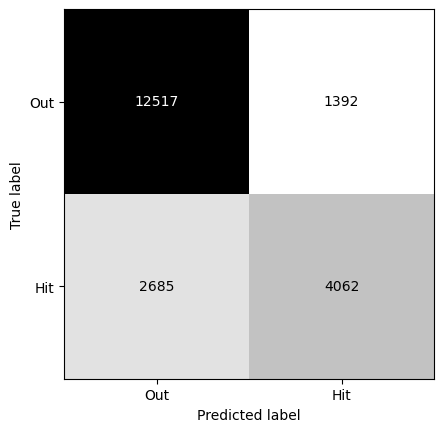

In [6]:
cm_ao = confusion_matrix(data['is_hit'], always_out)
cm_statcast = confusion_matrix(data['is_hit'], np.round(data['estimated_ba_using_speedangle']))

eda_scores = pd.DataFrame([cm_scores(data['is_hit'], always_out), 
                           cm_scores(data['is_hit'], np.round(data['estimated_ba_using_speedangle']))],
                           index=["Always Out", "Statcast"])
print(eda_scores)

ConfusionMatrixDisplay.from_predictions(y_true=data['is_hit'], y_pred=np.round(data['estimated_ba_using_speedangle']),
                                        display_labels=["Out", "Hit"], colorbar=False, cmap="binary");

# Distributions

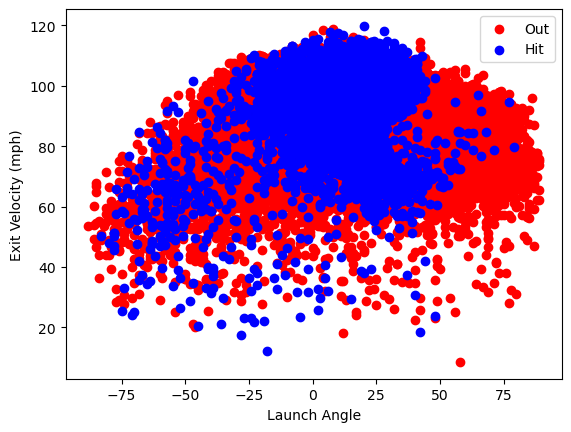

In [7]:
out_data = data[data['is_hit'] == 0]
hit_data = data[data['is_hit'] == 1]
plt.scatter(out_data['launch_angle'], out_data['launch_speed'], c="red",label="Out")
plt.scatter(hit_data['launch_angle'], hit_data['launch_speed'], c="blue",label="Hit")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();

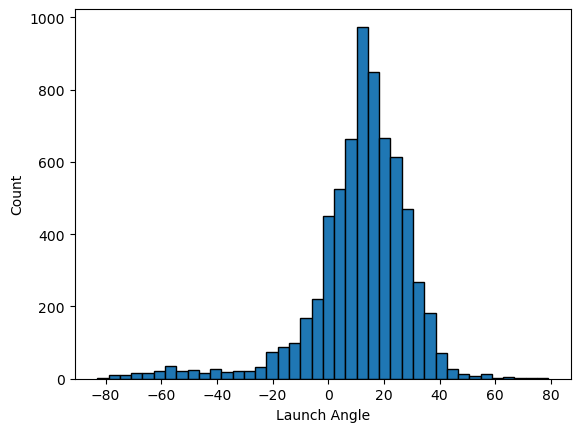

In [8]:
plt.hist(hit_data['launch_angle'], bins=40, ec='black')
plt.xlabel("Launch Angle")
plt.ylabel("Count");

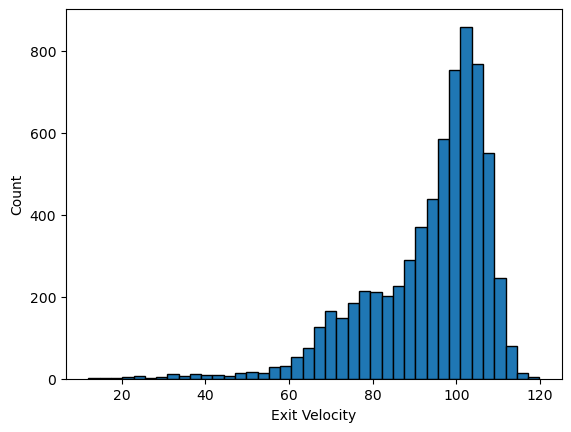

In [9]:
plt.hist(hit_data['launch_speed'], bins=40, ec='black');
plt.xlabel("Exit Velocity")
plt.ylabel("Count");